# ML Pipeline

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import statsmodels.api as sm
from scipy import stats
import time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_regression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Global variables

In [2]:
random_state = 42

In [3]:
total_cores = os.cpu_count()
available_cores = total_cores - 2

## Import data

In [4]:
al_basrah = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_al_basrah_2019-01-01-2022-12-31.csv"
al_basrah_large = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_al_basrah_large_2019-01-01-2022-12-31.csv"
al_jubayl = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_al_jubayl_2019-01-01-2022-12-31.csv"
al_jubayl_large = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_al_jubayl_large_2019-01-01-2022-12-31.csv"
ras_tanurah = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_ras_tanurah_2019-01-02-2022-12-31.csv"
ras_tanurah_large = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_ras_tanurah_large_2019-01-02-2022-12-31.csv"
fujairah = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_fujairah_2019-01-01-2022-12-31.csv"
fujairah_large = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_fujairah_large_2019-01-01-2022-12-31.csv" 

mongstad = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_mongstad_2021-01-01-2022-12-31.csv"
mongstad_large = "https://raw.githubusercontent.com/ericcg123/data/main/predictors_mongstad_large_2021-01-01-2022-12-31.csv"
# Load your dataset
data = pd.read_csv(al_jubayl)
port_name = "al_jubayl"
data.shape

(2652, 85)

In [5]:
# Feature shapes
print(f"Al Basrah shape:{pd.read_csv(al_basrah).shape}")
print(f"Al Basrah large shape:{pd.read_csv(al_basrah_large).shape}")
print(f"Al Jubayl shape:{pd.read_csv(al_jubayl).shape}")
print(f"Al Jubayl large shape:{pd.read_csv(al_jubayl_large).shape}")
print(f"Ras Tanurah shape:{pd.read_csv(ras_tanurah).shape}")
print(f"Ras tanurah large shape:{pd.read_csv(ras_tanurah_large).shape}")
print(f"Fujairah shape:{pd.read_csv(fujairah).shape}")
print(f"Fujairah large shape:{pd.read_csv(fujairah_large).shape}")

Al Basrah shape:(3575, 92)
Al Basrah large shape:(3290, 92)
Al Jubayl shape:(2652, 85)
Al Jubayl large shape:(1553, 85)
Ras Tanurah shape:(3957, 86)
Ras tanurah large shape:(3296, 86)
Fujairah shape:(5196, 111)
Fujairah large shape:(1693, 111)


In [6]:
#data = data[(data["vessel_class"]=="VLCC")|(data["vessel_class"]=="Suezmax")|(data["vessel_class"]=="ULCC")]

#data.shape

### File name variables

In [7]:
start_date = pd.to_datetime(data["start"].min()).date()
end_date = pd.to_datetime(data["end"].max()).date()
n_obs = len(data)

### Identify port spesific variables

In [8]:
def parse_list(input_list):
    result = []
    for item in input_list:
        if isinstance(item, str) and (item.startswith("berth") or item.startswith("SPM")):
            result.append(item)
    return result

In [9]:
berth_SPM_variables = parse_list(list(data.columns))

In [10]:
all_other_variables = [x for x in list(data.columns) if x not in berth_SPM_variables]

In [11]:
def extract_vessel_classes(input_list):
    result = []
    for item in input_list:
        if isinstance(item, str) and "vessel_class" in item:
            result.append(item)
    return result

In [12]:
ordinal_vars = extract_vessel_classes(list(data.columns))

### Convert vessel class to ordinal integer

In [13]:
def map_vessel_classes(df):
    vessel_classes = ["No vessel", "Sub Handysize", "Handysize", "Panamax", "Aframax", "Suezmax", "VLCC", "ULCC"]
    category_map = {category: idx for idx, category in enumerate(vessel_classes)}

    for column in ordinal_vars:
        if column in df.columns:
            df[column] = df[column].map(category_map)
            
    return df

In [14]:
data = map_vessel_classes(data)

### Convert time variables to integers

In [15]:
def convert_to_minutes(val):
    try:
        return round(pd.to_timedelta(val) / pd.Timedelta(minutes=1))
    except ValueError:
        return 0

In [16]:
def filter_time_elements(lst):
    time_lst = []
    for element in lst:
        if "time" in element:
            time_lst.append(element)
    return time_lst

In [17]:
# Extract time variables
time_vars = filter_time_elements(data.columns)

In [18]:
for col in time_vars:
    data[col] = data[col].apply(convert_to_minutes)

### Remove no wait

In [19]:
#data = data[data["wait_time"]>0]

### Remove outliers in wait time col

In [20]:
def remove_outliers_iqr(df, column_names):
    """
    Remove rows with outliers in the specified DataFrame columns using the IQR method.

    :param df: A pandas DataFrame
    :param column_names: The names of the columns in the DataFrame as a list
    :return: A new DataFrame with outliers removed
    """
    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Column '{column_name}' not found in the DataFrame")

    condition = True
    for column_name in column_names:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        condition = condition & ((df[column_name] >= lower_bound) & (df[column_name] <= upper_bound))

    return df[condition]


In [21]:
data = remove_outliers_iqr(data, ["wait_time", 'mean_wait_time3',
 'mean_wait_time6',
 'mean_wait_time12',
 'mean_wait_time24',
 'mean_wait_time48',
 'mean_wait_time72',])


### Separate features (X) and target (y)

In [22]:
drop_cols =['wait_time', 'imo', 'type', 'number', 'start', 'trip_number', 'time_berth','anchor_start', "end", "typnum",'anchor_number',]
X = data.drop(drop_cols, axis=1)
y = data['wait_time']

### Split train and test data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

### Encode categorical variables

In [24]:
one_hot_vars = ['hour_of_day','day_of_week', 'month_of_year', "pred_berth", "ShiptypeLevel5", 'pred_berth']

vessel_classes = ["No vessel","Sub Handysize", "Handysize", "Panamax", "Aframax", "Suezmax", "VLCC", "ULCC"]

In [25]:
def filter_lists(input_list, exclude_list1, exclude_list2):
    return [x for x in input_list if x not in exclude_list1 and x not in exclude_list2]

In [26]:
# Define lists for variable names
numeric_vars = filter_lists(list(data.columns), drop_cols, one_hot_vars)

### Define pre-processor

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_vars),
       # ('cat_ordinal', OrdinalEncoder(categories="auto"), ordinal_vars),
        ('cat_onehot', OneHotEncoder(handle_unknown="ignore"), one_hot_vars),
       # ('time_diff', TimeDifferenceTransformer(), time_vars)
    ])


### Define models

In [28]:
models = [
    ("simple_mean", Pipeline([
        ("preprocessor", preprocessor),
        ("model", DummyRegressor(strategy="mean"))
    ])),
    ("linear_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ])),
    ("lasso_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("model", Lasso(random_state=42))
    ])),
    ("ridge_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("model", Ridge(random_state=42))
    ])),
    ("support_vector_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("model", SVR())
    ])),
    ("random_forest", Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(random_state=42))
    ])),
    ("xgboost", Pipeline([
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(random_state=42))
    ])),
]

### Define hyper parameters

In [29]:
param_grids = {
    "lasso_regression": {
    "model__alpha": [0.001, 0.01, 0.1, 1, 10]
    },
    "ridge_regression": {
        "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
    },
    "support_vector_regression": {
        "model__kernel": ["linear", "rbf", "poly"],
        "model__C": [0.1, 1, 10],
        "model__epsilon": [0.01, 0.1, 1]
    },
    "random_forest": {
        "model__n_estimators": [100, 200, 300, 400, 500],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
    },
    "xgboost": {
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.1, 0.3],
        "model__max_depth": [3, 6, 9],
        "model__gamma": [0, 0.1, 0.3, 0.5, 1, 3],
        #"model__alpha": [0, 0.1, 0.3, 0.5, 1, 3],  # L1 regularization (alpha)
        #"model__lambda": [0.1, 0.3, 0.5, 1, 3],   # L2 regularization (lambda)
    },
}

### Tune models

In [30]:
tuned_models = []
training_times = {}  # Create a dictionary to store training times
for name, pipeline in models:
    start_time = time.time()  # Record the start time
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=10, n_jobs=available_cores, scoring="neg_mean_absolute_error")
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        print(f"{name} - Best parameters: {grid_search.best_params_}")
        tuned_models.append((name, best_estimator))
    else:
        pipeline.fit(X_train, y_train)
        tuned_models.append((name, pipeline))
    end_time = time.time()  # Record the end time
    training_time = end_time - start_time  # Calculate the training time
    training_times[name] = training_time  # Store the training time in the training_times dictionary

lasso_regression - Best parameters: {'model__alpha': 10}
ridge_regression - Best parameters: {'model__alpha': 100}
support_vector_regression - Best parameters: {'model__C': 10, 'model__epsilon': 0.01, 'model__kernel': 'linear'}
random_forest - Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 300}
xgboost - Best parameters: {'model__gamma': 3, 'model__learning_rate': 0.01, 'model__max_depth': 9, 'model__n_estimators': 100}


In [31]:
# Calculate the MSE and MAE of the simple_mean model
simple_mean_mse = mean_squared_error(y_test, [y_train.mean()] * len(y_test))
simple_mean_mae = mean_absolute_error(y_test, [y_train.mean()] * len(y_test))

# Initialize an empty list to store results
results = []

# Evaluate the performance of the tuned models
for name, model in tuned_models:
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    y_pred_train = model.predict(X_train)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    perc_improv_mse = (simple_mean_mse - mse_test) / simple_mean_mse * 100
    perc_improv_mae = (simple_mean_mae - mae_test) / simple_mean_mae * 100
    
    results.append({"model": name, "mse_test": mse_test, "mae_test": mae_test,
                    "mse_train": mse_train, "mae_train": mae_train,
                    "perc_improv_mse": perc_improv_mse, "perc_improv_mae": perc_improv_mae,
                    "training_time": training_times[name]})  # Add the training_time to the results
# Create a pandas DataFrame from the results list
results_df = pd.DataFrame(results)

In [32]:

# Step 1: Preprocess the data using scikit-learn's ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_vars),
        ('cat_onehot', OneHotEncoder(handle_unknown="ignore"), one_hot_vars),
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert preprocessed data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

# Step 2: Create a custom PyTorch dataset and dataloader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Increase batch size
batch_size = 64

train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        layers = [
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        ]

        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)
        return x

# Step 4: Train the neural network using cross-validation to tune hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Move the data to the device
X_train_tensor, y_train_tensor = X_train_tensor.to(device), y_train_tensor.to(device)
X_test_tensor, y_test_tensor = X_test_tensor.to(device), y_test_tensor.to(device)

# Create new train and test datasets on
train_dataset_gpu = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset_gpu = CustomDataset(X_test_tensor, y_test_tensor)

# Create new dataloaders on the GPU
train_dataloader_gpu = DataLoader(train_dataset_gpu, batch_size=batch_size, shuffle=True)
test_dataloader_gpu = DataLoader(test_dataset_gpu, batch_size=batch_size, shuffle=False)

# Hyperparameters to tune
# Add more hidden layers and neurons
hidden_sizes = [(8,8),(8,16),(16,16),(8,16,8)]
learning_rates = [0.001, 0.01]
num_epochs = 2000

# Initialize the results DataFrame for the neural network
results = pd.DataFrame(columns=["model", "mse_test", "mae_test", "mse_train", "mae_train"])

# Cross-validation
kf = KFold(n_splits=5)
best_loss = float("inf")
best_model = None
best_epoch = None

# Define a list of weight decay values to try
weight_decays = [1e-6, 1e-5, 1e-4]
dropout_rates = [0.1, 0.2, 0.3]

patience = 100
start_time = time.time()

for hidden_size in hidden_sizes:
    for learning_rate in learning_rates:
        for weight_decay in weight_decays:
            for dropout_rate in dropout_rates:
                print(f"Training with hidden_size: {hidden_size}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, dropout_rate: {dropout_rate}")

                model = NeuralNetwork(X_train_tensor.shape[1], hidden_size, 1, dropout_rate=dropout_rate).to(device)
                criterion = nn.MSELoss()
                optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

                # Initialize variables for early stopping
                epochs_without_improvement = 0
                best_val_loss = float("inf")

                for epoch in range(num_epochs):
                    train_model(model, train_dataloader_gpu, criterion, optimizer, device)
                    
                    val_loss = evaluate_model(model, test_dataloader_gpu, criterion, device)

                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model = model
                        best_epoch = epoch
                        epochs_without_improvement = 0  # Reset the counter
                    else:
                        epochs_without_improvement += 1

                    # Print the loss every 200 epochs
                    if (epoch + 1) % 500 == 0:
                        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}")

                    # Early stopping
                    if epochs_without_improvement >= patience:
                        print(f"Early stopping at epoch {epoch+1}, best epoch: {best_epoch}, best loss: {best_val_loss}")
                        break
end_time = time.time()
neural_network_training_time = end_time - start_time
# Move the best model to the device
best_model.to(device)

# Final evaluation
mse_train = evaluate_model(best_model, train_dataloader_gpu, criterion, device)
mse_test = evaluate_model(best_model, test_dataloader_gpu, criterion, device)

mse_criterion = nn.MSELoss(reduction='none')
mae_criterion = nn.L1Loss(reduction='none')

# Evaluate MAE and MSE for the train dataset
train_mae_losses = []
with torch.no_grad():
    for X_batch, y_batch in train_dataloader_gpu:
        output = best_model(X_batch)
        mse_loss = mse_criterion(output, y_batch)
        mae_loss = mae_criterion(output, y_batch)
        train_mae_losses.append(mae_loss.cpu().numpy())
mae_train = np.mean(np.concatenate(train_mae_losses, axis=0))

# Evaluate MAE and MSE for the test dataset
test_mae_losses = []
with torch.no_grad():
    for X_batch, y_batch in test_dataloader_gpu:
        output = best_model(X_batch)
        mse_loss = mse_criterion(output, y_batch)
        mae_loss = mae_criterion(output, y_batch)
        test_mae_losses.append(mae_loss.cpu().numpy())
mae_test = np.mean(np.concatenate(test_mae_losses, axis=0))

# Store the results in the DataFrame
neural_network_result = pd.DataFrame([{
    "model": "neural_network",
    "mse_test": mse_test,
    "mae_test": mae_test,
    "mse_train": mse_train,
    "mae_train": mae_train,
    "training_time": neural_network_training_time  # Add the training_time to the neural_network_result
}])
                                                              
# Concatenate the neural network result with the original results_df
results_df = pd.concat([results_df, neural_network_result], ignore_index=True)
# Calculate the percentage improvement over simple_mean for mse and mae
results_df["perc_improv_mse"] = (results_df["mse_test"][0] - results_df["mse_test"]) / results_df["mse_test"][0] * 100
results_df["perc_improv_mae"] = (results_df["mae_test"][0] - results_df["mae_test"]) / results_df["mae_test"][0] * 100




Training with hidden_size: (8, 8), learning_rate: 0.001, weight_decay: 1e-06, dropout_rate: 0.1
Early stopping at epoch 189, best epoch: 88, best loss: 61067.758984375
Training with hidden_size: (8, 8), learning_rate: 0.001, weight_decay: 1e-06, dropout_rate: 0.2
Early stopping at epoch 231, best epoch: 130, best loss: 58011.51640625
Training with hidden_size: (8, 8), learning_rate: 0.001, weight_decay: 1e-06, dropout_rate: 0.3
Early stopping at epoch 213, best epoch: 112, best loss: 60511.894140625
Training with hidden_size: (8, 8), learning_rate: 0.001, weight_decay: 1e-05, dropout_rate: 0.1
Early stopping at epoch 270, best epoch: 169, best loss: 58712.1173828125
Training with hidden_size: (8, 8), learning_rate: 0.001, weight_decay: 1e-05, dropout_rate: 0.2
Early stopping at epoch 263, best epoch: 162, best loss: 62451.398828125
Training with hidden_size: (8, 8), learning_rate: 0.001, weight_decay: 1e-05, dropout_rate: 0.3
Early stopping at epoch 216, best epoch: 115, best loss: 615

In [33]:
pd.options.display.float_format = '{:.2f}'.format
results_df["port"] = port_name 
results_df

,model,mse_test,mae_test,mse_train,mae_train,perc_improv_mse,perc_improv_mae,training_time,port
0,simple_mean,116325.46,211.00,105449.90,196.49,0.00,0.00,0.01,al_jubayl
1,linear_regression,74578.98,180.14,57963.81,153.56,35.89,14.63,0.03,al_jubayl
2,lasso_regression,68487.72,151.69,67631.06,143.22,41.12,28.11,4.21,al_jubayl
3,ridge_regression,68541.58,162.97,61408.04,148.58,41.08,22.76,0.26,al_jubayl
4,support_vector_regression,104946.85,129.44,94141.19,111.74,9.78,38.65,41.52,al_jubayl
5,random_forest,62290.69,120.06,13380.88,51.93,46.45,43.10,405.73,al_jubayl
6,xgboost,82253.39,117.37,26294.92,55.88,29.29,44.37,237.31,al_jubayl
7,neural_network,85198.86,145.10,17000.63,59.83,26.76,31.23,401.69,al_jubayl


### Save results

In [34]:
results_df.to_csv(f"results_{port_name}__n_{n_obs}_{start_date}-{end_date}.csv", index = False)

### Inspect results plots etc. 

In [35]:
def convert_to_timestamp(results_df):
    # Make a copy of the dataframe
    df = results_df.copy()

    # Convert the columns to timedelta format
    df[['mae_test', 'mae_train']] = df[['mae_test', 'mae_train']].applymap(lambda x: pd.Timedelta(minutes=x))

    # Convert the timestamps to a string format
    df[['mae_test', 'mae_train']] = df[['mae_test', 'mae_train']].applymap(lambda x: str(x))

    return df


In [36]:
#convert_to_timestamp(results_df)[["model","mae_test","mae_train","perc_improv_mse", "perc_improv_mae"]].sort_values("mae_test")

### Extract feature importance

In [37]:
def get_feature_importances(model, feature_names):
    importances = []
    
    if hasattr(model, "coef_"):
        importances = model.coef_.flatten()
    elif hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    elif hasattr(model, "n_support_"):  # Check if the model is SVR
        # Calculate the absolute values of the product of the support vectors and their corresponding dual coefficients
        importances = np.abs(np.matmul(model.support_vectors_.T, model.dual_coef_.T)).flatten()
    else:
        raise NotImplementedError("The feature importances extraction is not implemented for this model.")
    
    return pd.Series(importances, index=feature_names)


feature_names = get_transformed_feature_names(preprocessor)

# Create a dictionary to store feature importances
feature_importances = {}

# Loop through the models and extract feature importances
for name, pipeline in tuned_models:
    try:
        importances = get_feature_importances(pipeline.named_steps["model"], feature_names)
        if len(importances) > 0:
            feature_importances[name] = importances
    except NotImplementedError as e:
        print(e)
        continue


# Check if feature_importances is not empty
if feature_importances:
    # Create a DataFrame with the feature importances
    feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index', columns=feature_names)

else:
    print("No feature importances available for the given models.")

    
def normalize_feature_importances(df):
    abs_df = df.abs()
    return abs_df.apply(lambda row: row / row.sum(), axis=1)

normalized_feature_importances_df = normalize_feature_importances(feature_importances_df)

def normalize_feature_importances_and_sum(df):
    abs_df = df.abs()
    normalized_df = abs_df.apply(lambda row: row / row.sum(), axis=1)
    summed_importances = normalized_df.sum(axis=0)
    return normalized_df, summed_importances

normalized_feature_importances_df, summed_importances = normalize_feature_importances_and_sum(feature_importances_df)

features_summary_df = pd.DataFrame(normalized_feature_importances_df.columns, columns=['feature'])
for model in normalized_feature_importances_df.index:
    features_summary_df[model] = normalized_feature_importances_df.loc[model].values
features_summary_df['summed_value'] = summed_importances.values
features_summary_df["port_name"] = port_name

features_summary_df = features_summary_df.sort_values('summed_value', ascending=False).reset_index(drop=True)

NameError: name 'get_transformed_feature_names' is not defined

In [ ]:
features_summary_df[["feature", "summed_value"]].head(20)

In [ ]:
features_summary_df.to_csv(f"feature_imp_{port_name}__n_{n_obs}_{start_date}-{end_date}.csv", index = False)

In [ ]:
features_summary_df

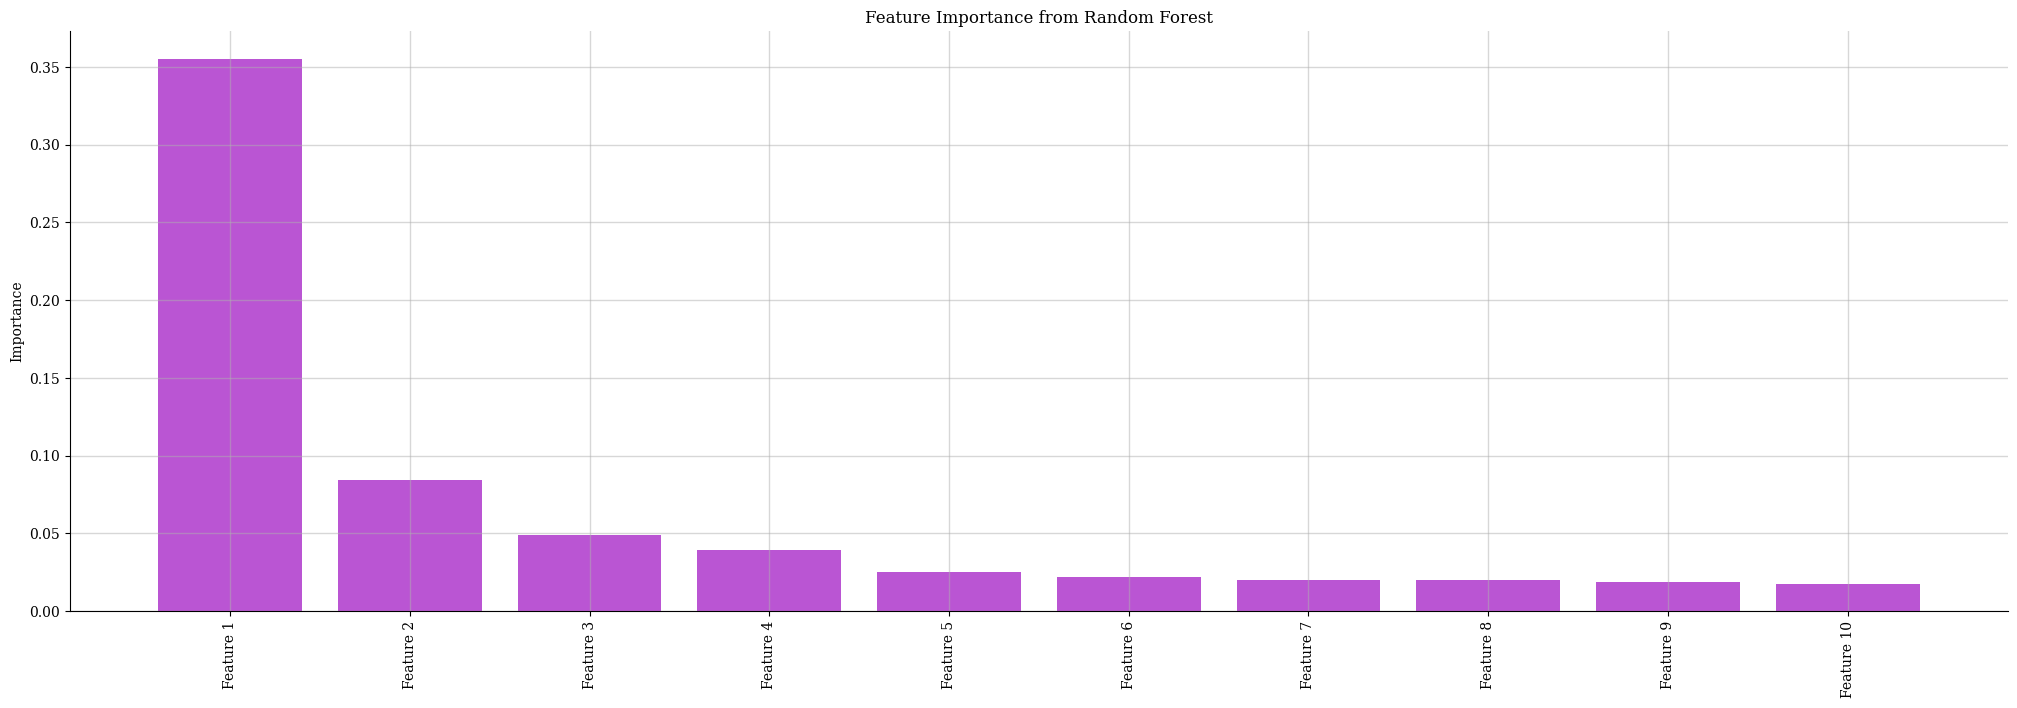

In [38]:
import matplotlib.pyplot as plt

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

# Extract the Random Forest model from tuned_models
rf_model = None
for name, model in tuned_models:
    if name == "random_forest":
        rf_model = model.named_steps["model"]
        break

if rf_model is None:
    raise ValueError("Random Forest model not found")

# Calculate feature importances and sort their indices
importances = rf_model.feature_importances_
sorted_idx = importances.argsort()

transformed_feature_names = preprocessor.get_feature_names_out()
transformed_feature_names = [feature_name.replace("num_", "").replace("_", " ") for feature_name in transformed_feature_names]
# Apply the preprocessor to X_train
X_train_transformed = preprocessor.fit_transform(X_train)
n_features = X_train_transformed.shape[1]

# Plot feature importances
plt.figure(figsize=(25, 10))
plt.bar(range(1, 11), importances[sorted_idx][-10:][::-1], align='center', color=palette[-1]) # use reverse order indices to plot the bars in opposite order
plt.xticks(range(1, 11), ["Feature " + str(i) for i in range(1, 11)], rotation=90) # use custom labels for x-axis ticks
plt.ylabel('Importance')
plt.title('Feature Importance from Random Forest')

# Adjust the bottom margin of the plot
plt.subplots_adjust(bottom=0.3)

# Save the plot as a high-resolution image
plt.savefig("feature_importance_random_forest.png", dpi=300)

# Manually edit the x-axis tick labels
#ax = plt.gca()
#ax.set_xticklabels(["Education", "Marital Status", "Capital Gain", "Age", "Hours per Week", "Relationship", "Occupation", "Workclass", "Race", "Sex"])

# Show the plot
plt.show()

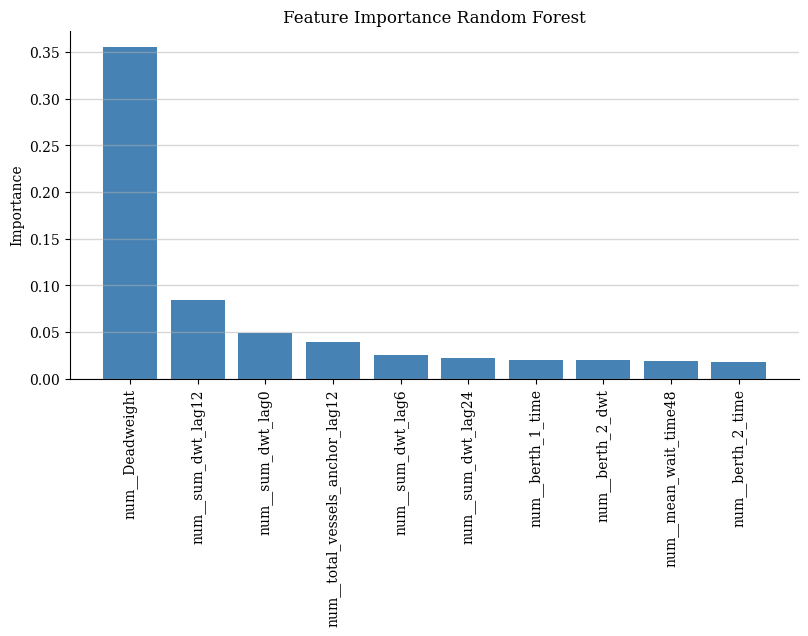

In [39]:
import matplotlib.pyplot as plt

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

# Extract the Random Forest model from tuned_models
rf_model = None
for name, model in tuned_models:
    if name == "random_forest":
        rf_model = model.named_steps["model"]
        break

if rf_model is None:
    raise ValueError("Random Forest model not found")

# Calculate feature importances and sort their indices
importances = rf_model.feature_importances_
sorted_idx = importances.argsort()

transformed_feature_names = preprocessor.get_feature_names_out()
# Apply the preprocessor to X_train
X_train_transformed = preprocessor.fit_transform(X_train)
n_features = X_train_transformed.shape[1]

# Get transformed feature names
transformed_feature_names = preprocessor.get_feature_names_out()

# Plot feature importances
plt.figure(figsize=(9.4, 6))
plt.bar(range(1, 11), importances[sorted_idx][-10:][::-1], align='center', color=palette[1]) # use reverse order indices to plot the bars in opposite order
plt.xticks(range(1, 11), transformed_feature_names[sorted_idx][-10:][::-1], rotation=90) # use reverse order indices to label the x-axis in opposite order
plt.ylabel('Importance')
plt.title('Feature Importance Random Forest')

# Adjust the bottom margin of the plot
plt.subplots_adjust(bottom=0.3)
# Manually edit the x-axis tick labels
#ax = plt.gca()
#ax.set_xticklabels(["Education", "Marital Status", "Capital Gain", "Age", "Hours per Week", "Relationship", "Occupation", "Workclass", "Race", "Sex"])
# Save the plot as a high-resolution image
plt.grid(axis='x')

plt.savefig("feature_importance_random_forest.pdf", dpi=600)

# Show the plot
plt.show()


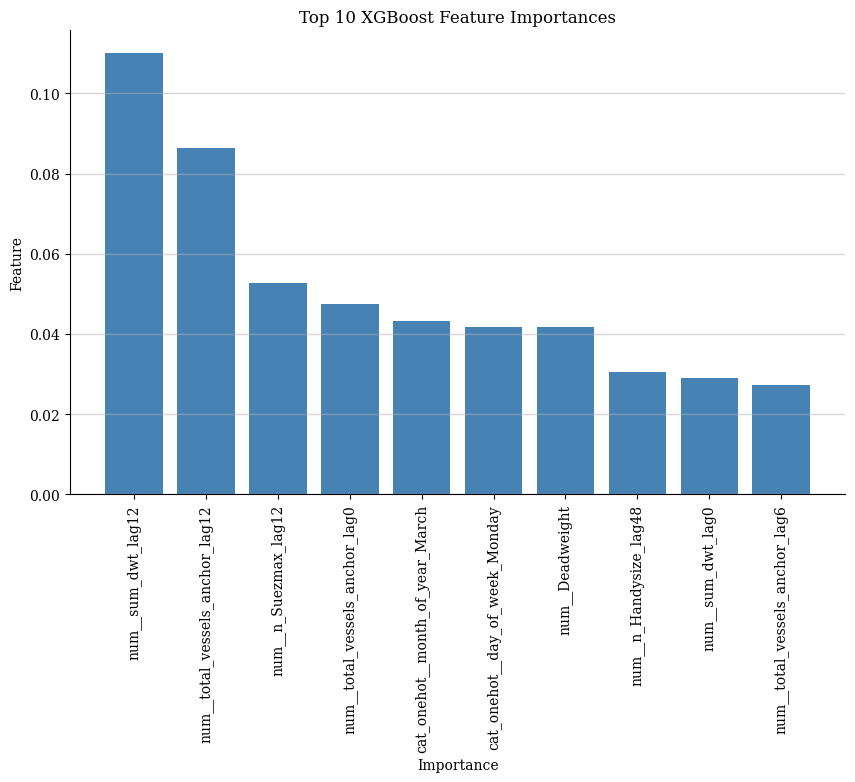

In [40]:
import matplotlib.pyplot as plt

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

# Set number of features to show
num_features = 10

# Extract the XGBoost model from the tuned_models list
for name, model in tuned_models:
    if name == "xgboost":
        xgb_model = model.named_steps["model"]
        break

# Get feature importances from the model
feature_importances = xgb_model.feature_importances_
sorted_idx = feature_importances.argsort()[::-1][:num_features]  # get indices of top num_features features

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color=palette[1])
plt.xticks(range(len(sorted_idx)), np.array(preprocessor.get_feature_names_out())[sorted_idx], rotation=90)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.title(f'Top {num_features} XGBoost Feature Importances')

# Adjust the bottom margin of the plot
plt.subplots_adjust(bottom=0.3)

# Show only vertical grid lines
plt.grid(axis='x')

# Show the plot
plt.show()



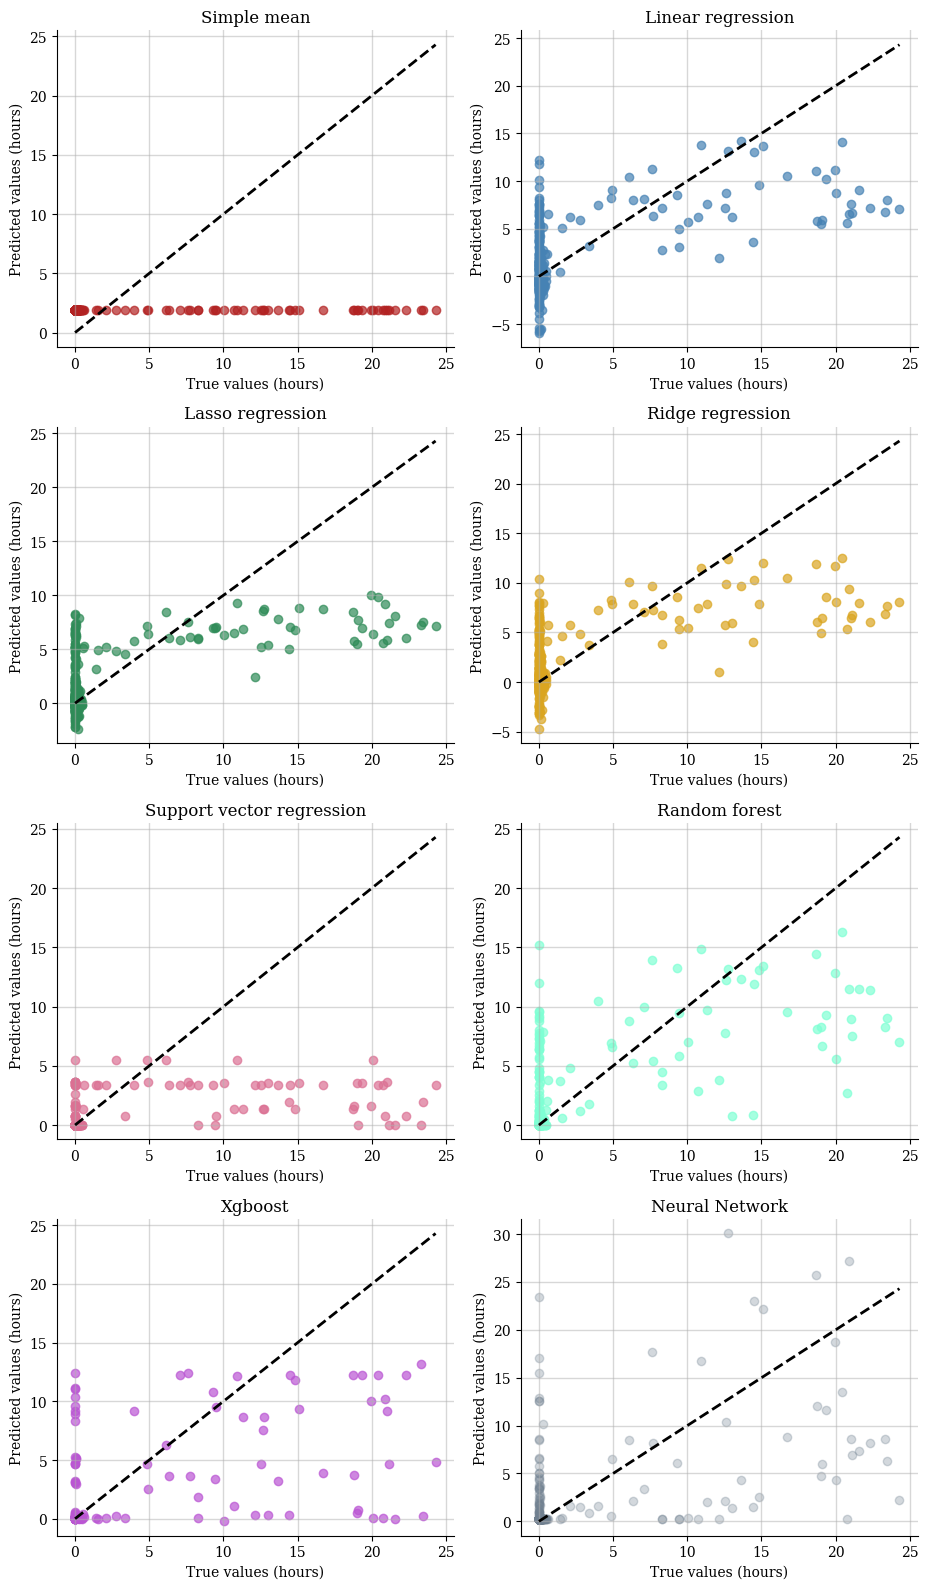

In [41]:
import matplotlib.pyplot as plt

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid", "slategrey"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

# Scatter plot of predictions versus the truth for each model
num_plots = len(tuned_models) + 1
num_rows = (num_plots + 1) // 2
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(9.4, 4 * num_rows))
axes = axes.flatten()  # Flatten the axes array to easily index it

for idx, (name, model) in enumerate(tuned_models):
    y_pred = model.predict(X_test)
    
    ax = axes[idx]
    ax.scatter(y_test/60, y_pred/60, alpha=0.7, color=palette[idx%len(palette)])
    ax.plot([y_test.min()/60, y_test.max()/60], [y_test.min()/60, y_test.max()/60], 'k--', lw=2)
    ax.set_xlabel("True values (hours)")
    ax.set_ylabel("Predicted values (hours)")
    name = name.replace('_', ' ').capitalize()
    ax.set_title(f"{name}")
    ax.xaxis.grid(True)

# Add neural network model
y_pred_nn = best_model(X_test_tensor.to(device)).cpu().detach().numpy()
ax = axes[len(tuned_models)]
ax.scatter(y_test/60, y_pred_nn/60, alpha=0.3, color=palette[-1])
ax.plot([y_test.min()/60, y_test.max()/60], [y_test.min()/60, y_test.max()/60], 'k--', lw=2)
ax.set_xlabel("True values (hours)")
ax.set_ylabel("Predicted values (hours)")
ax.set_title("Neural Network")
ax.xaxis.grid(True)

# Remove unused subplots
for i in range(num_plots, num_rows * 2):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.rcParams['font.size'] = 12
plt.show()
fig.savefig(f"pred_vs_truth_{port_name}.pdf",bbox_inches='tight', dpi=600)


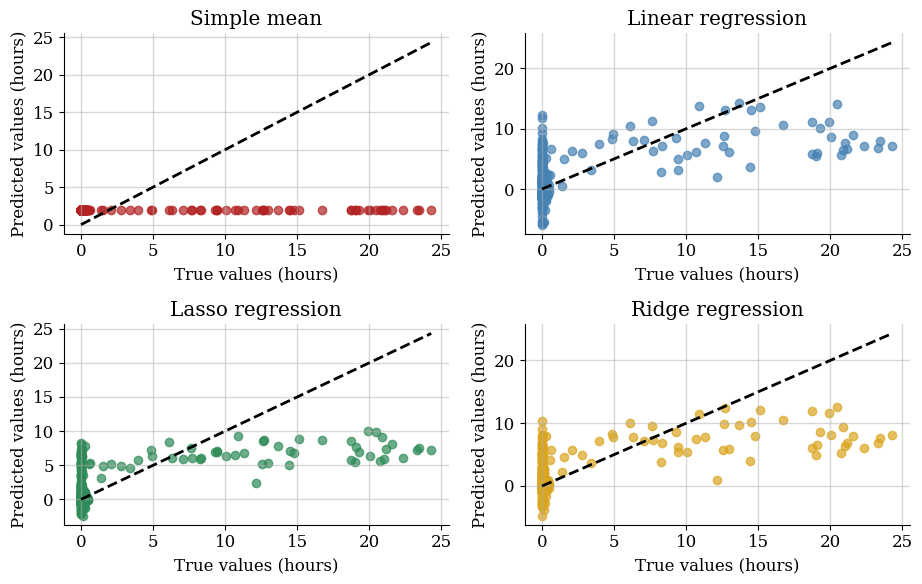

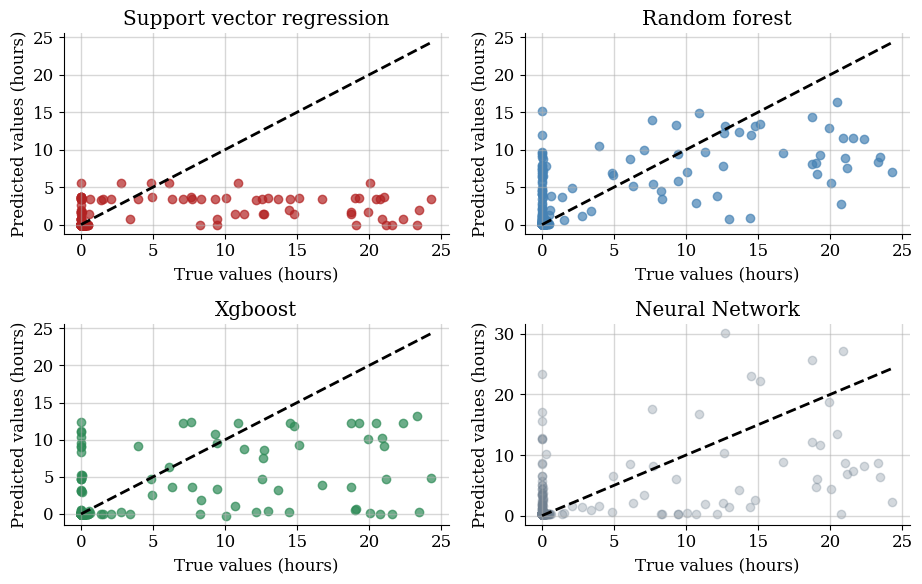

In [46]:
import matplotlib.pyplot as plt
import math

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid", "slategrey"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

num_plots = len(tuned_models) + 1
half_plots = math.ceil(num_plots / 2)

# Helper function to create subplots
def create_subplots(fig, axes, models):
    for idx, (name, model) in enumerate(models):
        y_pred = model.predict(X_test)

        ax = axes[idx]
        ax.scatter(y_test/60, y_pred/60, alpha=0.7, color=palette[(idx) % len(palette)])
        ax.plot([y_test.min()/60, y_test.max()/60], [y_test.min()/60, y_test.max()/60], 'k--', lw=2)
        ax.set_xlabel("True values (hours)")
        ax.set_ylabel("Predicted values (hours)")
        name = name.replace('_', ' ').capitalize()
        ax.set_title(f"{name}")
        ax.xaxis.grid(True)

# First set of subplots
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(9.4, 6))
axes1 = axes1.flatten()
create_subplots(fig1, axes1, tuned_models[:half_plots])

plt.tight_layout()
plt.show()
fig1.savefig(f"pred_vs_truth_1_{port_name}.pdf", bbox_inches='tight', dpi=600)

# Second set of subplots
fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(9.4, 6))
axes2 = axes2.flatten()
create_subplots(fig2, axes2, tuned_models[half_plots:num_plots - 1])

# Add neural network model
y_pred_nn = best_model(X_test_tensor.to(device)).cpu().detach().numpy()
ax = axes2[-1]
ax.scatter(y_test/60, y_pred_nn/60, alpha=0.3, color=palette[-1])
ax.plot([y_test.min()/60, y_test.max()/60], [y_test.min()/60, y_test.max()/60], 'k--', lw=2)
ax.set_xlabel("True values (hours)")
ax.set_ylabel("Predicted values (hours)")
ax.set_title("Neural Network")
ax.xaxis.grid(True)

plt.tight_layout()
plt.show()
fig2.savefig(f"pred_vs_truth_2_{port_name}.pdf", bbox_inches='tight', dpi=600)



In [ ]:
import matplotlib.pyplot as plt

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

# Set number of features to show
num_features = 10

# Extract the SVR model from the tuned_models list
for name, model in tuned_models:
    if name == "support_vector_regression":
        svr_model = model.named_steps["model"]
        break

# Get feature importances from the model coefficients
feature_importances = abs(svr_model.coef_[0])
sorted_idx = feature_importances.argsort()[::-1][:num_features]  # get indices of top num_features features

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color=palette[1])
plt.xticks(range(len(sorted_idx)), np.array(preprocessor.get_feature_names_out())[sorted_idx], rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title(f'Top {num_features} SVR weights')

# Adjust the bottom margin of the plot
plt.subplots_adjust(bottom=0.3)

# Show only vertical grid lines
plt.grid(axis='x')

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

# Set number of features to show
num_features = 10

# Extract the Ridge model from the tuned_models list
for name, model in tuned_models:
    if name == "ridge_regression":
        ridge_model = model.named_steps["model"]
        break

# Get feature importances from the model coefficients
feature_importances = abs(ridge_model.coef_)
sorted_idx = feature_importances.argsort()[::-1][:num_features]  # get indices of top num_features features

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color=palette[1])
plt.xticks(range(len(sorted_idx)), np.array(preprocessor.get_feature_names_out())[sorted_idx], rotation=90)
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.title(f'Top {num_features} Ridge Regression Coefficients')

# Adjust the bottom margin of the plot
plt.subplots_adjust(bottom=0.3)

# Show only vertical grid lines
plt.grid(axis="x")

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,
          "grid.alpha": 0.5,
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}

plt.rcParams.update(params)

# Set number of features to show
num_features = 10

# Extract the Ridge model from the tuned_models list
for name, model in tuned_models:
    if name == "lasso_regression":
        ridge_model = model.named_steps["model"]
        break

# Get feature importances from the model coefficients
feature_importances = abs(ridge_model.coef_)
sorted_idx = feature_importances.argsort()[::-1][:num_features]  # get indices of top num_features features

# Plot feature importances
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center', color=palette[1])
plt.xticks(range(len(sorted_idx)), np.array(preprocessor.get_feature_names_out())[sorted_idx], rotation=90)
plt.ylabel('Coefficient Value')
plt.xlabel('Feature')
plt.title(f'Top {num_features} Ridge Regression Coefficients')

# Adjust the bottom margin of the plot
plt.subplots_adjust(bottom=0.3)

# Show only vertical grid lines
plt.grid(axis="x")

# Show the plot
plt.show()

In [ ]:
from sklearn.tree import plot_tree

# Find and plot a tree from the random forest
for name, model in tuned_models:
    if name == "random_forest":
        rf_model = model.named_steps["model"]
        break

# Plot the first tree
fig, ax = plt.subplots(figsize=(100, 50))
plot_tree(rf_model.estimators_[0], ax=ax, filled=True, feature_names=preprocessor.get_feature_names_out(),)

# Save the plot as a high-resolution image
fig.savefig("random_forest_tree.png", dpi=300)

# Close the plot to avoid displaying it in Jupyter Lab
plt.close(fig)


# DIV

In [ ]:
models = [
        ("simple_mean", Pipeline([
        ("preprocessor", preprocessor),
        ("model", DummyRegressor(strategy="mean")),
            
    ("linear_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("selector", SelectKBest(f_regression, k=10)),
        ("model", LinearRegression())
    ])),
    ("lasso_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("selector", SelectKBest(f_regression, k=10)),
        ("model", Lasso(random_state=42))
    ])),
    ("ridge_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("selector", SelectKBest(f_regression, k=10)),
        ("model", Ridge(random_state=42))
    ])),
    ("support_vector_regression", Pipeline([
        ("preprocessor", preprocessor),
        ("selector", SelectKBest(f_regression, k=10)),
        ("model", SVR())
    ])),
    ("random_forest", Pipeline([
        ("preprocessor", preprocessor),
        ("selector", SelectKBest(f_regression, k=10)),
        ("model", RandomForestRegressor(random_state=42))
    ])),
    ("xgboost", Pipeline([
        ("preprocessor", preprocessor),
        ("selector", SelectKBest(f_regression, k=10)),
        ("model", XGBRegressor(random_state=42))
    ])),
    ("neural_network", Pipeline([
        ("preprocessor", preprocessor),
        ("selector", SelectKBest(f_regression, k=10)),
        ("model", MLPRegressor(random_state=42, max_iter=8000))
    ])),
]

param_grids = {
    "lasso_regression": {
        "selector__k": [5, 10, 20, 50, 80, 100],
        "model__alpha": [0.001, 0.01, 0.1, 1, 10]
    },
    "ridge_regression": {
        "selector__k": [5, 10, 20, 50, 80, 100],
        "model__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
    },
    "support_vector_regression": {
        "selector__k": [5, 10, 20, 50, 80, 100],
        "model__kernel": ["linear", "rbf", "poly"],
        "model__C": [0.1, 1, 10],
        "model__epsilon": [0.01, 0.1, 1]
    },
    "random_forest": {
        "selector__k":[5, 10, 20, 50, 80, 100],
        "model__n_estimators": [100, 200, 300],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
    },
    "xgboost": {
        "selector__k": [5, 10, 20, 50, 80, 100],
        "model__n_estimators": [100, 200, 300],
        "model__learning_rate": [0.01, 0.1, 0.3],
        "model__max_depth": [3, 6, 9],
    },
    "neural_network": {
    "selector__k": [5, 10, 20, 50, 80, 100],
    "model__hidden_layer_sizes": [(32,), (64,) ,(32, 32), (64, 64)],
    "model__activation": ["relu"],
    "model__learning_rate_init": [0.001, 0.01],
    "model__alpha": [0.0001, 0.001, 0.01, 0.1],
},

    }

tuned_models = []
for name, pipeline in models:
    if name in param_grids:
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=available_cores, scoring="neg_mean_absolute_error")
        grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        print(f"{name} - Best parameters: {grid_search.best_params_}")
        tuned_models.append((name, best_estimator))
    else:
        pipeline.fit(X_train, y_train)
        tuned_models.append((name, pipeline))

### Plot graphs

In [ ]:
import matplotlib as plt
palette = ['firebrick', 'steelblue', "seagreen", "goldenrod", "palevioletred", "aquamarine", "mediumorchid"]

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.spines.top": False,
          "axes.spines.left": True,
          "axes.spines.right": False,
          "axes.spines.bottom": True,
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "axes.grid": True,           # Add this line to enable the grid
          "grid.alpha": 0.5,           # Add these lines to customize the grid
          "grid.linewidth": 1,
          "text.usetex" : False,
          "font.family" : "serif",
          'font.sans-serif' : ['Computer Modern Sans Serif'],
          "axes.prop_cycle": plt.cycler(color=palette)}
plt.rcParams.update(params)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def scatter_plot(df, x_col, y_col, category_col):
    categories = df[category_col].unique()
    
    fig, ax = plt.subplots(figsize=(10,8))
    plt.gca().set_prop_cycle(params['axes.prop_cycle'])   # Set the color cycle from params
    
    for category in categories:
        category_data = df[df[category_col]==category]
        ax.scatter(category_data[x_col], category_data[y_col]/60, label=category, alpha=0.5)
    
    ax.set_xlabel("Deadweight tons")
    ax.set_ylabel("Wait time in hours")
    ax.legend()

    plt.show()


In [ ]:
def scatter_plot(df, x_col, y_col, category_col):
    categories = df[category_col].unique()
    
    fig, ax = plt.subplots(figsize=(10,8))
    
    # Define the desired order of the legend entries
    category_order = ["Sub Handysize", "Handysize", "Panamax", "Aframax", "Suezmax", "VLCC", "ULCC"]
    
    # Set the colors for each category
    colors = plt.cm.tab10.colors[:len(categories)]
    
    # Create a dictionary to map the category labels to their corresponding colors
    color_dict = dict(zip(categories, colors))
    
    for category in category_order:
        if category in categories:
            category_data = df[df[category_col]==category]
            ax.scatter(category_data[x_col], category_data[y_col]/60, label=category, alpha=0.5, color=color_dict[category])
    
    ax.set_xlabel("Deadweight tons")
    ax.set_ylabel("Wait time in hours")
    
    # Format the x-axis tick labels with a thousand separator
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x).replace(",", " ")))
    
    # Create a flat legend below the chart with no border
    handles, labels = ax.get_legend_handles_labels()
    legend_dict = dict(zip(labels, handles))
    legend_handles = [legend_dict[label] for label in category_order if label in legend_dict]
    legend_labels = [label for label in category_order if label in legend_dict]
    legend = ax.legend(handles=legend_handles, labels=legend_labels, ncol=len(categories), mode="expanded", loc="upper center", bbox_to_anchor=(0.5, -0.07), frameon=False)
    
    plt.show()


In [ ]:
scatter_plot(data.sort_values("wait_time"), "Deadweight", "wait_time", "vessel_class")

### Fully connected multilayer perceptron feedforward artificial neural network

In [ ]:
results_df